In [1]:
from mrsqm import MrSQMClassifier, MrSQMTransformer
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import timeit

from sklearn.linear_model import RidgeClassifierCV

from aeon.datasets import load_classification  

## Load dataset

Load dataset with *aeon*:
https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.datasets.load_classification.html

In [2]:
ds = "Coffee"
X_train, y_train = load_classification(name=ds,split="train")
X_test, y_test = load_classification(name=ds,split="test")

print(ds)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Coffee
(28, 1, 286) (28,)
(28, 1, 286) (28,)


## Train with MrSQMClassifier

In [3]:
clf = MrSQMClassifier().fit(X_train,y_train)

## Test the model

In [4]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9642857142857143


## Use MrSQM Transformer

In [5]:
tfm = MrSQMTransformer()

In [6]:
X_train_transform = tfm.fit_transform(X_train,y_train)
X_test_transform = tfm.transform(X_test)

In [7]:
# use ridgecv classifier
ridge = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10)).fit(X_train_transform,y_train)
y_pred = ridge.predict(X_test_transform)
print(metrics.accuracy_score(y_test, y_pred))

0.9642857142857143


## Explanation with saliency map
A saliency map is basically a weight vector for each point in the time series corresponding to a class. Higher weight means the data point is more relevant to the class according to the model.

*get_saliency_map* return a c X L array where c is the number of class and L is the length of the time series.

It is important to note that in MrSQM saliency map only works if there is at least 1 SAX representation used for training.

In [32]:
# This example visualise the saliency map of the 1st sample (class '0') in the Coffee dataset 
clf = MrSQMClassifier(nsax=5,nsfa=0).fit(X_train,y_train)
x = X_train[0,0,:]
w = clf.get_saliency_map(x)[0,:]


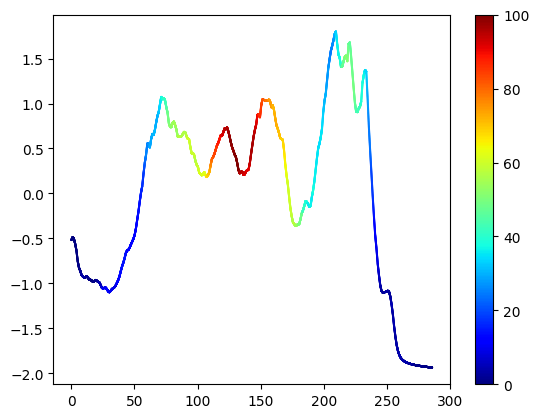

In [33]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt



def transform(X):
    ma,mi = np.max(X), np.min(X)
    X = (X - mi)/(ma-mi)
    return X*100
weight = abs(w)
weight = transform(weight)
ts = np.squeeze(x)
   
max_length1, max_length2 = ts.shape[0],10000 #
x1 = np.linspace(0,max_length1,num = max_length1)
x2 = np.linspace(0,max_length1,num = max_length2)
y1 = ts

f = interp1d(x1, y1) # interpolate time series
fcas = interp1d(x1, weight) # interpolate weight color
weight = fcas(x2) # convert vector of original weight vector to new weight vector

plt.scatter(x2,f(x2), c = weight, cmap = 'jet', marker='.', s= 1,vmin=0,vmax = 100)
# plt.xlabel('Explanation for index %d, dataset %s' %(idx, ds))
cbar = plt.colorbar(orientation = 'vertical')


plt.show()

## Control the number of SAX and SFA representations
The parameters *nsax* and *nsfa* control the number of SAX and SFA representations produced from the raw data. The number of representations is *nsax* (or *nsfa*) x log(L) where L is the length of the time series.

Adding more representations (bigger *nsax* or *nsfa*) can improve the accuracy but slow down the training.

In [10]:
starttime = timeit.default_timer()
clf = MrSQMClassifier(nsax=1, nsfa=3).fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)

0.9642857142857143
Time to train and predict (sec): 1.340001734904945


In [11]:
#parameters about training that the user can change
'''     
    Overview: MrSQM is an efficient time series classifier utilizing symbolic representations of time series. MrSQM implements four different feature selection strategies (R,S,RS,SR) that can quickly select subsequences from multiple symbolic representations of time series data.
    def __init__(self, strat = 'RS', features_per_rep = 500, selection_per_rep = 2000, nsax = 1, nsfa = 0, custom_config=None, random_state = None, sfa_norm = True):

    Parameters
    ----------
    
    strat               : str, feature selection strategy, either 'R','S','SR', or 'RS'. R and S are single-stage filters while RS and SR are two-stage filters. By default set to 'RS'.
    features_per_rep    : int, (maximum) number of features selected per representation. By deafault set to 500.
    selection_per_rep   : int, (maximum) number of candidate features selected per representation. Only applied in two stages strategies (RS and SR). By deafault set to 2000.
    nsax                : int, control the number of representations produced by sax transformation.
    nsfa                : int, control the number of representations produced by sfa transformation.
    custom_config       : dict, customized parameters for the symbolic transformation.
    random_state        : set random seed for classifier. By default 'none'.
    ts_norm             : time series normalisation (standardisation). By default set to 'True'.
    '''

starttime = timeit.default_timer()
clf = MrSQMClassifier(random_state=42,nsax=0, nsfa=1, sfa_norm = 'False').fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)


1.0
Time to train and predict (sec): 0.29645546339452267
